# Imports and Definitions of functions

In [31]:
import pandas as pd
from tqdm.notebook import tqdm as tqdm_notebook
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import seaborn as sns
from itertools import combinations
%matplotlib inline

# Data reading

In [5]:
FILE_ORIGIN = '../dblpv13.json'
FILE_PREPROCESSED = '../data.json'

Используйте этот скрипт один раз, чтобы создать удобочитаемый json

In [6]:
# with open(FILE_ORIGIN, 'r') as f_origin, open(FILE_PREPROCESSED, 'w+') as f_preprocessed:
#     for line in tqdm_notebook(f_origin, total=450000000):
#         new_line = re.sub(r'NumberInt\((\d*)\)', r'\1', line)
#         if new_line in ('[\n', ']\n'):
#             new_line = ''
#         if new_line == '},\n':
#             new_line = '}\n'
#         else:
#             new_line = new_line[:-1]
#         f_preprocessed.write(new_line)

Считываем только 1кк строк, чанками по 100к. Предполагается, что первые 1кк строк - репрезентативны

In [7]:
CHUNKSIZE = 100000
MAX_OBSERVATIONS = 1000000 #Set to 55000000 if want all rows
df = pd.DataFrame()
with pd.read_json(FILE_PREPROCESSED, orient='records', lines=True, chunksize=CHUNKSIZE, nrows=MAX_OBSERVATIONS) as reader:
    for chunk in tqdm_notebook(reader, total=MAX_OBSERVATIONS // CHUNKSIZE):
        df = pd.concat([df, pd.DataFrame(chunk)], ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

# EDA

In [8]:
df.sample(5)

,_id,title,venue,year,keywords,n_citation,lang,authors,fos,page_start,page_end,volume,issue,issn,isbn,doi,pdf,url,abstract,references
451156,53e99e28b7602d97026ed122,The new MSMPS Packet Scheduling Algorithm for ...,"{'_id': '555037b67cea80f954197084', 'name_d': ...",2012.0,"[packet switching, queueing theory, scheduling...",0.0,en,"[{'_id': '53f43114dabfaee02ac8fd51', 'name': '...","[Fair-share scheduling, Scheduling (computing)...",1,5,,,,,10.1109/CSNDSP.2012.6292793,None,[http://dx.doi.org/10.1109/CSNDSP.2012.6292793...,,"[53e99df7b7602d97026b7b9a, 53e9bcd9b7602d97049..."
940563,53e9a645b7602d9702f73b3c,A simple inductive synthesis methodology and i...,"{'_id': '5390acaf20f70186a0eb9d4c', 'type': 0,...",2010.0,"[linear time, second order]",60.0,en,"[{'_id': '53f46160dabfaee0d9c1b2e1', 'name': '...","[Program transformation, Second-order logic, C...",36,46,45,10,0362-1340,,10.1145/1869459.1869463,//static.aminer.org/pdf/20170130/pdfs/oopsla/j...,"[http://dx.doi.org/10.1145/1869459.1869463, ht...",Given a high-level specification and a low-lev...,"[53e9adb0b7602d97037adb5b, 53e9b6eeb7602d97042..."
408377,53e99d80b7602d970263d2c0,A Novel Interval Grey Number and Entropy-based...,"{'_id': '53a72d8a20f7420be8c693a9', 'name_d': ...",2012.0,"[target problem, grey relation model, ideal so...",3.0,en,"[{'_id': '53f3a239dabfae4b34ac14b9', 'name': '...","[Mathematical optimization, Multiple-criteria ...",349,356,,,,,10.1109/UIC-ATC.2012.93,None,"[http://dx.doi.org/10.1109/UIC-ATC.2012.93, ht...",Owing to the popularization of smart mobile de...,"[53e9b798b7602d9704341d4a, 53e9ba54b7602d97046..."
365811,53e99cd8b7602d9702589db7,ATPG for Design Errors-Is It Possible?,"{'_id': '53a727ba20f7420be8b9a28c', 'name_d': ...",2001.0,[],0.0,en,"[{'_id': '54899c82dabfae9b40134bd0', 'name': '...","[Automatic test pattern generation, Computer s...",283,283,,,,,,None,[http://doi.ieeecomputersociety.org/10.1109/VT...,,NaN
384957,53e99d21b7602d97025d917c,parallel_dp: the parallel dynamic programming ...,"{'_id': '539099c420f70186a0e1bc2f', 'name_d': ...",2013.0,"[tbb program, participant collaboration, paral...",1.0,en,"[{'_id': '53f4d3acdabfaeedd278160c', 'name': '...","[Dynamic programming, Computer science, Parall...",,,,,,,10.1145/2498328.2500056,None,"[http://dx.doi.org/10.1145/2498328.2500056, ht...",Intel Threading Building Blocks (TBB) is an id...,"[53e9b42fb7602d9703f266e7, 53e9b9e1b7602d97045..."


In [9]:
df.columns

Index(['_id', 'title', 'venue', 'year', 'keywords', 'n_citation', 'lang',
       'authors', 'fos', 'page_start', 'page_end', 'volume', 'issue', 'issn',
       'isbn', 'doi', 'pdf', 'url', 'abstract', 'references'],
      dtype='object')

## General columns understanding

Изначально хочется понять, что представляют из себя столбцы в плане предметной области

In [10]:
df._id.nunique()

1000000

_id ключ уникальный

In [12]:
df['venue_keys'] = df.venue.apply(lambda x: list(dict(x).keys()) if isinstance(x, dict) else [])

Столбце venue содержит словари, посмотрим распределение ключей в этих словарях

In [13]:
venue_keys = defaultdict(int)
for val in df.venue_keys:
    for key in val:
        venue_keys[key] += 1

In [14]:
print("Статистика по venue:")
for key, occurance in venue_keys.items():
    print(f'{key} встречался {occurance} раз')

Статистика по venue:
type встречался 846565 раз
_id встречался 853738 раз
name_d встречался 423651 раз
raw встречался 992216 раз
raw_zh встречался 101189 раз
publisher встречался 84634 раз
sid встречался 117511 раз
issn встречался 108616 раз
t встречался 117359 раз
online_issn встречался 36732 раз
name_s встречался 440 раз
name встречался 1168 раз
src встречался 27 раз


<pre>
Как видим ключи разнообразные, но можено сделать следующие выводы:
    - аттрибут обозначает журнал, в котором была опубликована статья
    - журнал имеет разнообразные ключи
</pre>

In [16]:
keywords = defaultdict(int)
for val in df.keywords:
    if not isinstance(val, list):
        keywords['nothing'] += 1
    else:
        for key in val:
            keywords[key] += 1

Столбец keyword - список, посмотрим на распределение его items

In [17]:
print("Статистика по top keywords:")
for key in sorted(keywords.keys(), key=lambda x: keywords[x], reverse=True)[:10]:
    print(f'{key} встречался {keywords[key]} раз')

Статистика по top keywords:
data mining встречался 18921 раз
computer science встречался 14347 раз
real time встречался 13243 раз
internet встречался 12936 раз
feature extraction встречался 11686 раз
computational complexity встречался 11410 раз
satisfiability встречался 11227 раз
neural network встречался 10006 раз
indexing terms встречался 9229 раз
protocols встречался 9153 раз


Тут все понятно

In [19]:
print(keywords['nothing'])

342


Очень мало observations, где у нас нет ниодного keyword - good

In [21]:
authors_keys = defaultdict(int)
for val in df.authors:
    if not isinstance(val, list):
        authors_keys['noone'] += 1
    else:
        for dic in val:
            for key in dict(dic):
                authors_keys[key] += 1

со столбцом authors сделаем тоже самое, что и с venue

In [22]:
print("Статистика по authors:")
for key, occurance in authors_keys.items():
    print(f'{key} встречался {occurance} раз')

Статистика по authors:
noone встречался 5661 раз
_id встречался 2676237 раз
name встречался 2724913 раз
org встречался 1479700 раз
gid встречался 1101776 раз
oid встречался 47530 раз
orgid встречался 1223383 раз
sid встречался 79856 раз
email встречался 406105 раз
orgs встречался 696741 раз
orcid встречался 104927 раз
bio встречался 43858 раз
name_zh встречался 924 раз
org_zh встречался 930 раз
oid_zh встречался 85 раз
orgs_zh встречался 198 раз


In [24]:
keywords_fos = defaultdict(int)
for val in df.fos:
    if not isinstance(val, list):
        keywords_fos['nothing'] += 1
    else:
        for key in val:
            keywords_fos[key] += 1

fos проанализируем точно также как и keywords

In [25]:
print("Статистика по top keywords_fos:")
for key in sorted(keywords_fos.keys(), key=lambda x: keywords_fos[x], reverse=True)[:10]:
    print(f'{key} встречался {keywords_fos[key]} раз')

Статистика по top keywords_fos:
Computer science встречался 579872 раз
Mathematics встречался 195720 раз
Artificial intelligence встречался 169219 раз
Algorithm встречался 78948 раз
Engineering встречался 60182 раз
Computer network встречался 58303 раз
Computer vision встречался 57436 раз
Discrete mathematics встречался 54400 раз
nothing встречался 52772 раз
Distributed computing встречался 47546 раз


По остальным полям все в принципе понятно

### Краткая статистика по полям

<pre>
_id - string, уникальное значение статьи
title - string, название статьи
venue - dict, информация о том, где была опубликована
    - _id - id места публикации 
    - name_d - название места публикации
    - дальше не понятно, возможные ключи можете увидеть выше
year - int, год публикации
keywords - list, ключивые слова статей
n_citation - int, количество цитирований
lang - string, язык
authors - list[dict], информация об авторах
    - смотреть статистику выше
fos - list, очень похоже на keywords, но пока не могу точно характеризовать в чем разница
page_start - int, номер страницы в публикации начиная с которой идет статья
page_end - int, номер страницы в публикации на которой заканчивается статья
volume - int, сколько лет статья уже публикуется
issue - int, сколько раз была опубликована в течении данного year
issn - string, уникальный номер, но есть не у всех
isbn - string, тоже уникальный номер, но есть не у всех
doi - string, тоже уникальный номер и тоже есть не у всех
pdf - string, выглядит как ссылка на статью в aminer
url - string, ссылка с использованием doi
abstract - string, краткое описание статьи
references - list[_id], id статей, которые цитировались в данной статье]
</pre>

## Keywords and Fos analysis

### Keywords

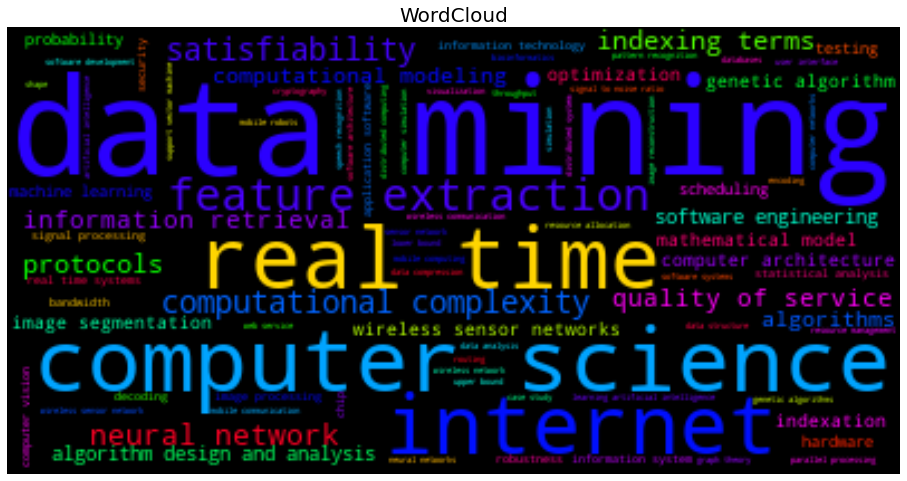

In [32]:
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(keywords)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud', size=20)
plt.show()

С помощью wordcloud можно наглядно увидеть распределение keywords

In [33]:
df['keywords_count'] = df.keywords.apply(lambda x: len(x) if isinstance(x, list) else 0)

Давайте построим распределение количества keywords для каждого observation

In [34]:
conditions = [
    df['keywords_count'] == 0,
    df['keywords_count'] == 1,
    df['keywords_count'].between(2, 5),
    df['keywords_count'].between(6, 15),
    df['keywords_count'] > 15,
]
choices = [ "keywords_count_0", 'keywords_count_1', 'keywords_count_2-5', 'keywords_count_6-15', 'keywords_count_>15']
df['keywords_count_type'] = np.select(conditions, choices, default=np.nan)

С нашей точки зрение на интересны данные типы количества keywords:
<pre>
    keywords_count_0 - нет ни одного keywords - ошибка или некачественная статья
    keywords_count_1 - один keywords - некачественная статья
    keywords_count_2-5 - небольшая статейка, узконаправленная
    keywords_count_6-15 - качественная работа типа диплома
    keywords_count_>15 - стлишком много keywords - все подряд
</pre>

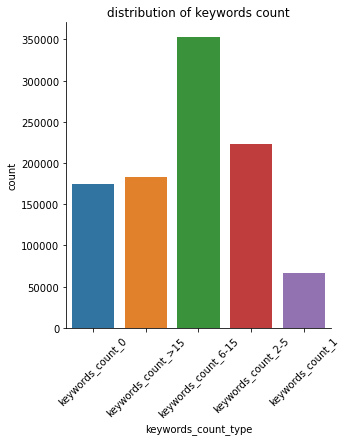

In [35]:
chart = sns.catplot(x="keywords_count_type", kind="count", data=df, ).set(title='distribution of keywords count')
chart.set_xticklabels(rotation=45)

За исключением того, что много статей без keywords. остальное нормально

In [36]:
counts_2_grams_keywords = defaultdict(int)
for sent in df.keywords:
    if isinstance(sent, list) and len(sent) >= 2:
        for word1, word2 in combinations(sent, 2):
            counts_2_grams_keywords[f'{min(word1, word2)}, {max(word1, word2)}'] += 1

До этого, мы строили wordcloud по одному слову, теперь давайте построим по связке из двух слов

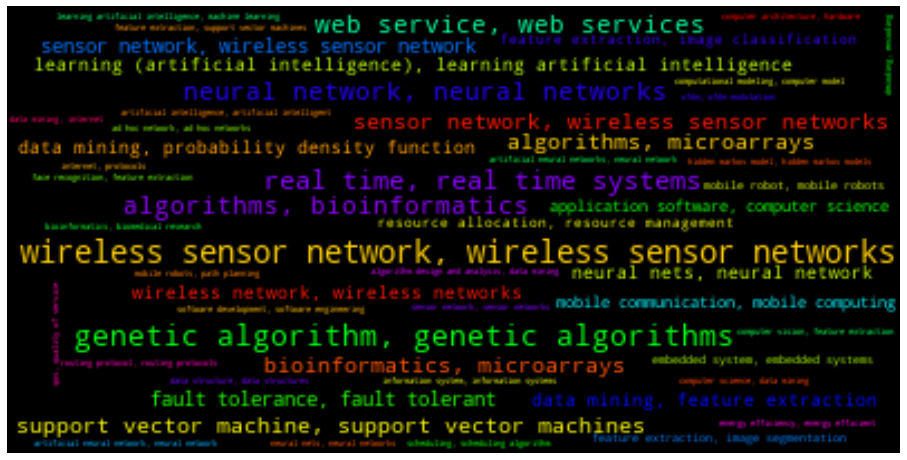

In [37]:
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(counts_2_grams_keywords)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Тут есть как хорошие примеры. так и плохие, плохих больше. Плохие примеры, это примеры, где 2 keywords имеют один и тот же смысл, от сюда можно сделать вывод о необходимости обработки stemming или lematizer

In [38]:
def boolean_df(item_lists, unique_items):
    bool_dict = {}
    
    for i, item in enumerate(unique_items):
        
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    return pd.DataFrame(bool_dict)

Давайте посмотрим на корреляцию между top 10 keywords

In [39]:
keywords_bool = boolean_df(df.loc[df.keywords_count > 0, 'keywords'], 
                      sorted(keywords.keys(), key=lambda x: keywords[x], reverse=True)[:10])

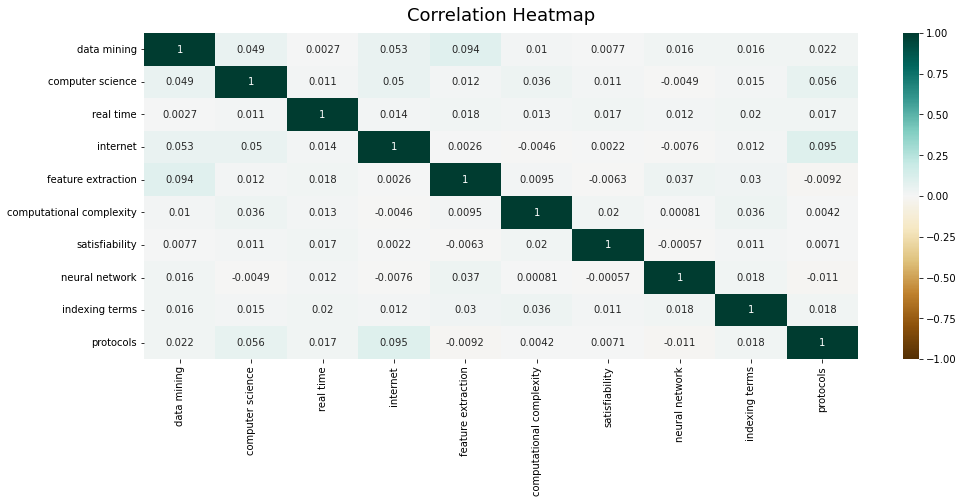

In [40]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(keywords_bool.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

Как видно коррелирующих top 10 keywords - нет

### FOS

Т.к. столбца Keywords и Fos похожи сделаем такой же анализ

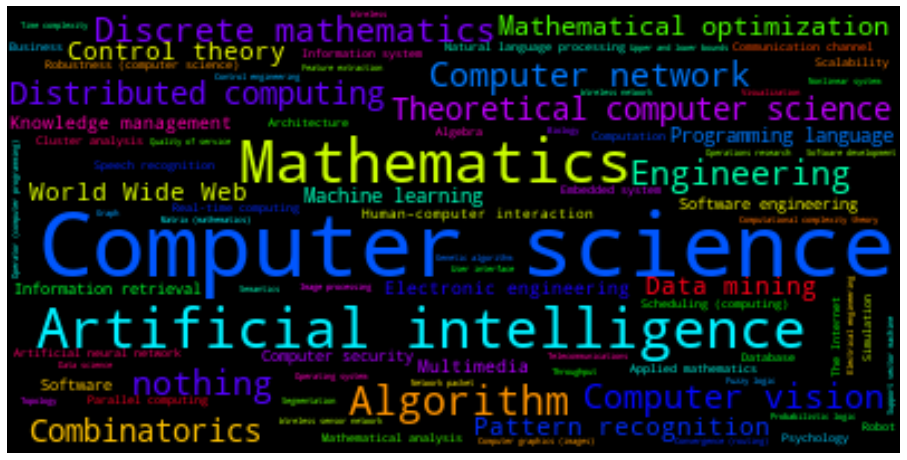

In [41]:
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(keywords_fos)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [42]:
df['fos_count'] = df.fos.apply(lambda x: len(x) if isinstance(x, list) else 0)

<AxesSubplot:xlabel='fos_count', ylabel='count'>

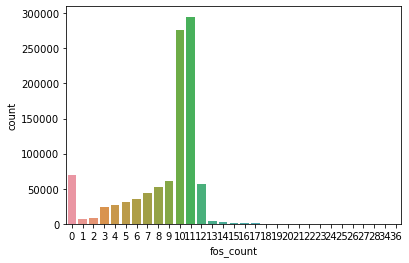

In [43]:
sns.countplot(x='fos_count', data=df)

Т.к. тут распределение более дискретное не будет группировать, а построим как есть

In [44]:
counts_2_grams_fos = defaultdict(int)
for sent in df.fos:
    if isinstance(sent, list) and len(sent) >= 2:
        for word1, word2 in combinations(sent, 2):
            counts_2_grams_fos[f'{min(word1, word2)}, {max(word1, word2)}'] += 1

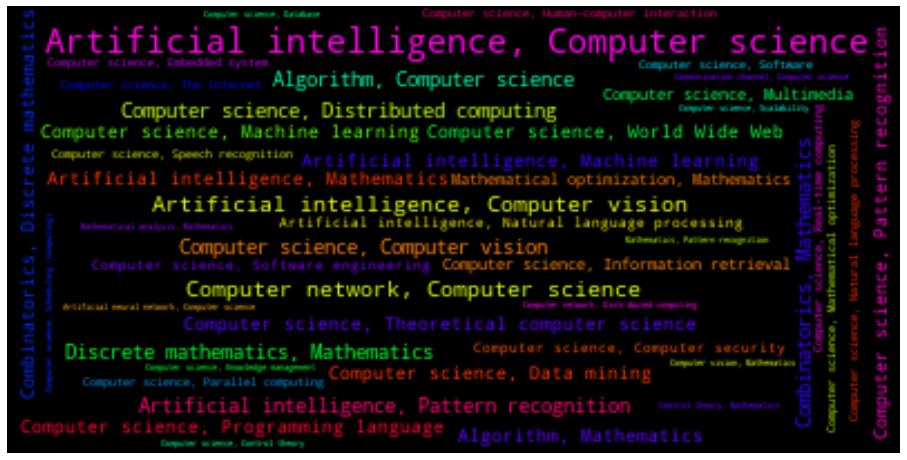

In [45]:
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(counts_2_grams_fos)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Тут ситуация лучше и красивее

In [46]:
fos_bool = boolean_df(df.loc[df.fos_count > 0, 'fos'], 
                      sorted(keywords_fos.keys(), key=lambda x: keywords_fos[x], reverse=True)[:10])

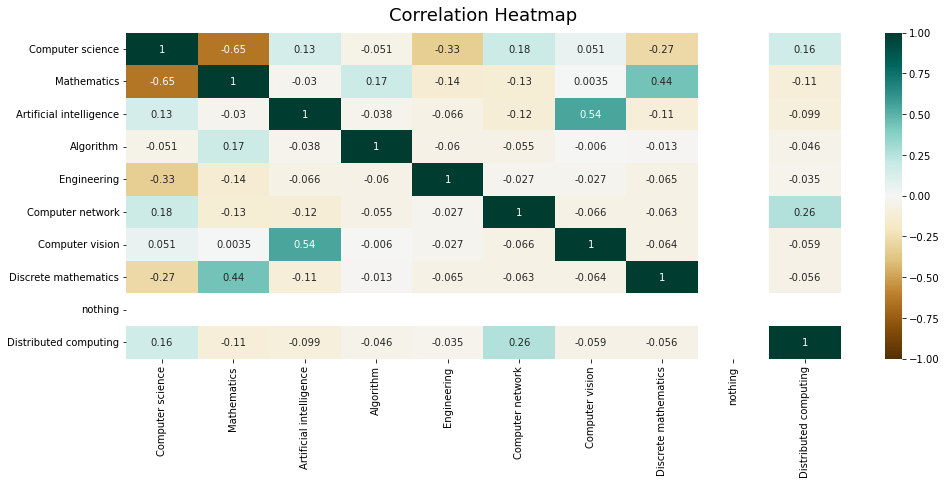

In [47]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(fos_bool.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

Тут можно заметить, что есть некоторые корреляции, как положительные, так и отрицательные

## Venue analysis

Статьи в одних и тех же журналах могут стать хорошим началом для рекоммендационной системы, давайте рассмотрим лучше данный столбец

In [48]:
print("Статистика по venue:")
for key in sorted(venue_keys.keys(), key=lambda x: venue_keys[x], reverse=True):
    print(f'{key} встречался {venue_keys[key]} раз')

Статистика по venue:
raw встречался 992216 раз
_id встречался 853738 раз
type встречался 846565 раз
name_d встречался 423651 раз
sid встречался 117511 раз
t встречался 117359 раз
issn встречался 108616 раз
raw_zh встречался 101189 раз
publisher встречался 84634 раз
online_issn встречался 36732 раз
name встречался 1168 раз
name_s встречался 440 раз
src встречался 27 раз


Как мы видим в основном у нас есть 4 ключа - raw, _id, type, name_d

In [49]:
df['venue_keys_string'] = df.venue_keys.apply(lambda x: ','.join(x))

In [51]:
df.venue_keys_string.value_counts()

_id,name_d,type,raw                       399853
_id,type,raw                              324210
_id,raw,raw_zh,publisher,type              42483
sid,issn,t,raw,publisher                   36698
sid,issn,t,raw                             35627
sid,issn,online_issn,t,raw                 35499
_id,raw,raw_zh,type                        32081
_id,raw                                    19045
_id,type,raw,raw_zh                        17680
name_d,type,raw                            10207
type,raw                                    8073
                                            7258
sid,t,raw                                   7035
_id,name_d,raw                              5919
_id,name_d,type,raw,raw_zh                  5665
raw,_id                                     3114
raw,raw_zh,publisher,type                   2429
_id,type,raw,publisher                      1652
_id,name_d,type,raw,publisher               1328
sid,online_issn,t,raw                        733
sid,name,t,raw      

В основном у нас есть 2 вида словариков: _id,name_d,type,raw и _id,type,raw

In [52]:
df[['venue_raw','venue_name_d','venue_type']] = df.venue.apply(
    lambda x: pd.Series([x.get('raw'), x.get('name_d'), x.get('type')]) if isinstance(x, dict) else pd.Series([None, None, None]))

Давайте посмотрим распределение каждого из ключей

<AxesSubplot:xlabel='venue_type', ylabel='count'>

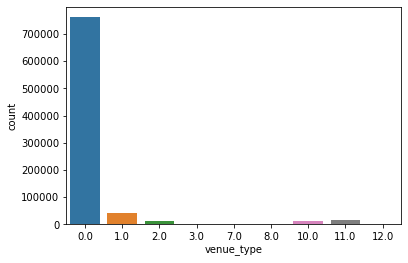

In [53]:
sns.countplot(x='venue_type', data=df)

Как мы видим у нас есть 12 типов type, чтобы они не значили. Давайте посмотрим, является ли type уникальным для каждого raw

In [54]:
type_mapping = df[df.venue_type.notna()].groupby('venue_raw')['venue_type'].nunique()

In [55]:
type_mapping[type_mapping > 1]

venue_raw
50 Years of Artificial Intelligence                                   2
A Half-Century of Automata Theory                                     2
AAAI                                                                  3
AAAI Fall Symposium: Biologically Inspired Cognitive Architectures    2
ACL                                                                   3
                                                                     ..
soft computing                                                        2
spring conference on computer graphics                                2
tools and algorithms for construction and analysis of systems         2
uncertainty in artificial intelligence                                2
workshop on information technologies and systems                      2
Name: venue_type, Length: 1604, dtype: int64

Как видим нет

In [56]:
name_mapping = df[df.venue_name_d.notna()].groupby('venue_raw')['venue_name_d'].nunique()

Хочется проверить является ли venue_name_d уикальной для каждого venue_raw

In [57]:
name_mapping[name_mapping > 1]

venue_raw
1999 ACM SIGMOD Workshop on Research Issues in Data Mining and Knowledge Discovery    2
2006 IEEE International Conference on Automation Science and Engineering, CASE        2
3DOR                                                                                  2
A Quarterly Journal of Operations Research                                            2
AAAI                                                                                  7
                                                                                     ..
parallel computing                                                                    3
prague stringology conference                                                         2
soft computing                                                                        3
technical symposium on computer science education                                     2
ubiquitous computing                                                                  2
Name: venue_name_d, Le

Как видим нет, давайте попробуем понять почему

In [58]:
df.loc[df.venue_raw.eq('AAAI'), ['venue_raw','venue_name_d']].value_counts()

venue_raw  venue_name_d                                            
AAAI       National Conference on Artificial Intelligence              1336
           Innovative Applications of Artificial Intelligence            33
           Conference on Learning Theory                                  1
           European Conference on Artificial Intelligence                 1
           Meeting of the Association for Computational Linguistics       1
           Neurocomputing                                                 1
           Science & Engineering Faculty                                  1
dtype: int64

https://aaai.org/Conferences/IAAI/iaai.php
Как видно у этих конференций одинаковый сайт, возможно из-за этого возникают ошибки

Давайте взглянем топ самых популярных журналов

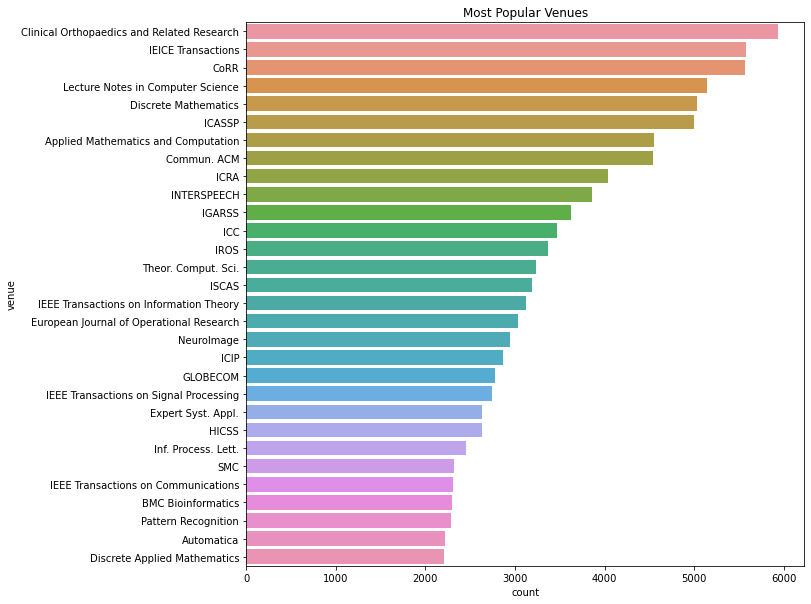

In [59]:
pop_ven = df.venue_raw.value_counts().reset_index()
pop_ven.columns = ['venue','count']

plt.figure(figsize = (10,10))
plt.title("Most Popular Venues")
sns.barplot(x = 'count', y = 'venue', data = pop_ven.head(30));

In [60]:
df_venue_year = df[df.year.between(1990, 2022)].groupby(['year', 'venue_raw']).size()

Давайте посмотрим распределение топ 3 журналов с 1990 по 2022 годы

In [61]:
df_venue_top_year = df_venue_year.sort_values().groupby(level=0).tail(3).reset_index().sort_values(by=['year', 0], ascending=False).rename(columns={0: 'count'})

In [62]:
df_venue_top_year

,year,venue_raw,count
2,2020.0,ACM SIGSOFT Software Engineering Notes,2
5,2020.0,Journal of Social Structure,2
1,2020.0,symposium on principles of database systems,1
3,2019.0,Wiley Encyclopedia of Computer Science and Eng...,2
4,2019.0,IEEE Transactions on Information Theory,2
...,...,...,...
23,1991.0,EUROSPEECH,131
19,1991.0,Theor. Comput. Sci.,99
21,1990.0,ICSLP,118
20,1990.0,Discrete Mathematics,100


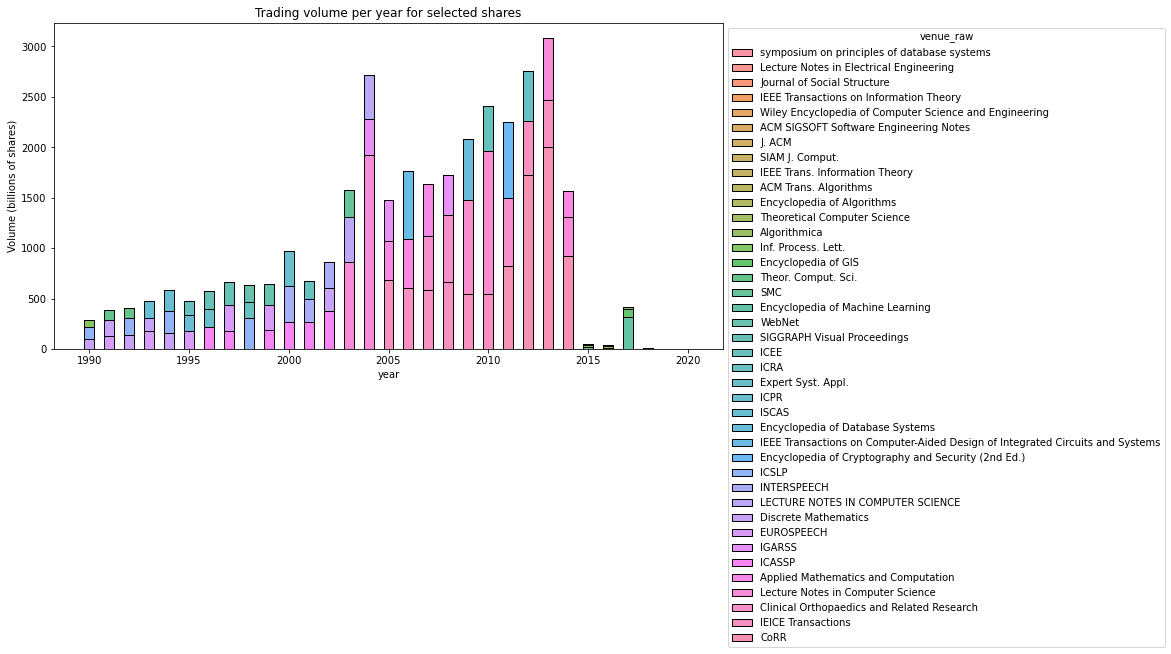

In [63]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = sns.histplot(
    data=df_venue_top_year,
    x="year",
    hue="venue_raw",
    weights="count",
    multiple="stack",
    shrink=0.5,
    discrete=True,
    hue_order=df_venue_top_year.groupby("venue_raw")['count'].sum().sort_values().index
)

ax.set_title("Trading volume per year for selected shares")
ax.set_ylabel("Volume (billions of shares)")

legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))

Ну если вгдялываться в цвета мб что-то и станет понятнее

## Top Most Cited

In [65]:
df.head()

,_id,title,venue,year,keywords,n_citation,lang,authors,fos,page_start,...,abstract,references,venue_keys,keywords_count,keywords_count_type,fos_count,venue_keys_string,venue_raw,venue_name_d,venue_type
0,53e99784b7602d9701f3e3f5,3GIO.,{'type': 0},2011.0,[],0.0,en,NaN,NaN,NaN,...,NaN,NaN,[type],0,keywords_count_0,0,type,NaN,NaN,0.0
1,53e99784b7602d9701f3e133,The relationship between canopy parameters and...,"{'_id': '53a7297d20f7420be8bd4ae7', 'name_d': ...",2011.0,"[canopy parameters, canopy spectrum, different...",0.0,en,"[{'_id': '53f45728dabfaec09f209538', 'name': '...","[Agronomy, Moisture, Hydrology, Environmental ...",1930,...,Drought is the first place in all the natural ...,NaN,"[_id, name_d, type, raw]",17,keywords_count_>15,11,"_id,name_d,type,raw",IGARSS,International Geoscience and Remote Sensing Sy...,0.0
2,53e99784b7602d9701f3e151,A solution to the problem of touching and brok...,"{'_id': '53a72a4920f7420be8bfa51b', 'name_d': ...",1993.0,"[handwriting recognition, prototypes, image se...",17.0,en,"[{'_id': '53f46797dabfaeb22f542630', 'name': '...","[Intelligent character recognition, Pattern re...",602,...,,"[53e99cf5b7602d97025ace63, 557e8a7a6fee0fe990c...","[_id, name_d, type, raw]",11,keywords_count_6-15,11,"_id,name_d,type,raw",ICDAR-1,International Conference on Document Analysis ...,0.0
3,53e99784b7602d9701f3e15d,Timing yield estimation using statistical stat...,"{'_id': '53a72e2020f7420be8c80142', 'name_d': ...",2005.0,"[sequential circuits, statistical distribution...",28.0,en,"[{'_id': '53f43b03dabfaedce555bf2a', 'name': '...","[Delay calculation, Timing failure, Monte Carl...",2461,...,As process variations become a significant pro...,"[53e9a8a9b7602d97031f6bb9, 599c7b6b601a182cd27...","[_id, name_d, type, raw]",33,keywords_count_>15,11,"_id,name_d,type,raw",ISCAS (3),International Symposium on Circuits and Systems,0.0
4,53e99784b7602d9701f3e161,360°,"{'_id': '5390a74a20f70186a0e8b40b', 'raw': 'AC...",2009.0,"[global high technology, daily short-distance ...",NaN,en,"[{'_id': '53f46946dabfaec09f24b4ed', 'name': '...",NaN,39,...,360° represents the concerns that are addresse...,NaN,"[_id, raw]",4,keywords_count_2-5,0,"_id,raw",ACM SIGGRAPH ASIA 2009 Art Gallery & Emerging ...,None,NaN


In [67]:
articles_cited = defaultdict(int)
for val in df.references:
    if isinstance(val, list):
        for art in val:
            articles_cited[art] += 1

In [82]:
top_cited = sorted(articles_cited, key=lambda x: articles_cited[x], reverse=True)[:25]

Text(0.5, 0, 'Number of citations')

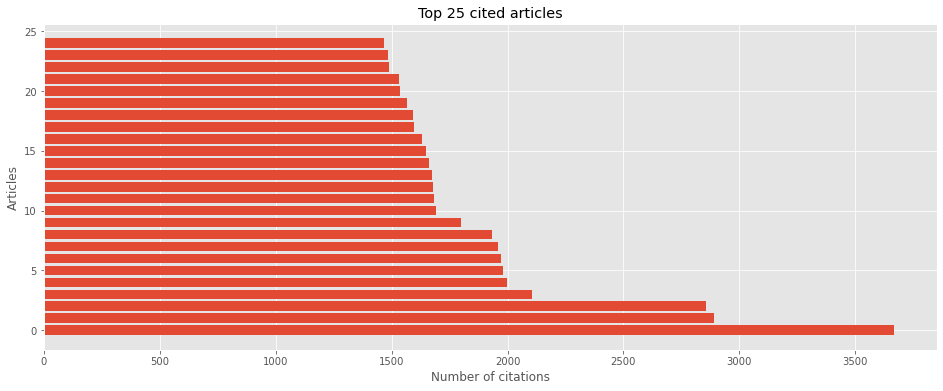

In [84]:
plt.style.use('ggplot')
plt.figure(figsize=(16, 6))
plt.barh([i for i in range(len(top_cited))], [articles_cited[x] for x in top_cited])
plt.title('Top 25 cited articles')
plt.ylabel('Articles')
plt.xlabel('Number of citations')

у насть есть хорошо цитируемые статьи - perfect